In [2]:
import torch
from annotator.canny import CannyDetector
from annotator.hed import HEDdetector
from annotator.util import HWC3, resize_image
from dataloaders import CLIC
import tqdm
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

In [4]:
class CannyTransform(torch.nn.Module):
    """Apply Canny Edge Detector to image
    """

    def __init__(self, low, high):
        super().__init__()
        self.low = low
        self.high = high
        self.hed = HEDdetector()

    def HWC3(self, x):
        assert x.dtype == np.uint8
        if x.ndim == 2:
            x = x[:, :, None]
        assert x.ndim == 3
        H, W, C = x.shape
        assert C == 1 or C == 3 or C == 4
        if C == 3:
            return x
        if C == 1:
            return np.concatenate([x, x, x], axis=2)
        if C == 4:
            color = x[:, :, 0:3].astype(np.float32)
            alpha = x[:, :, 3:4].astype(np.float32) / 255.0
            y = color * alpha + 255.0 * (1.0 - alpha)
            y = y.clip(0, 255).astype(np.uint8)
            return y


    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be Canny'd.

        Returns:
            Tensor: Canny edge map of image.
        """
        img = (255*img.permute(1,2,0)).numpy().astype(np.uint8)
        # img = cv2.Canny(self.HWC3(img), self.low, self.high)
        img = self.hed(self.HWC3(img))
        img = torch.tensor(img).unsqueeze(0)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

In [5]:
t = CannyTransform(100, 200)

Downloading: "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/network-bsds500.pth" to /home/eric/gitRepos/ControlNet/annotator/ckpts/network-bsds500.pth



100%|██████████| 56.1M/56.1M [00:00<00:00, 103MB/s] 


In [6]:
transform = transforms.Compose([
            transforms.CenterCrop(512),
            CannyTransform(100, 200),
        ])

In [8]:
clic = CLIC(root='/home/Shared/image_datasets/CLIC/2021', batch_size=1)

In [9]:
x = clic.train_dset[2][0]

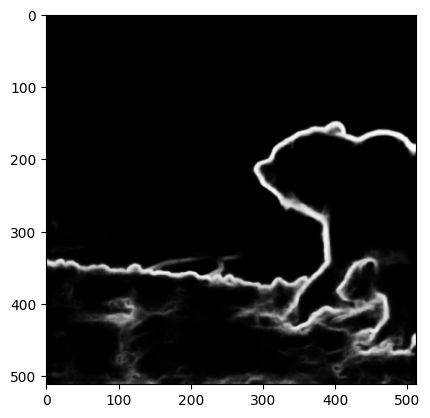

In [10]:
plt.imshow(transform(x).permute(1,2,0), cmap='gray')

In [22]:
def encode(im):
    apply_canny = CannyDetector()
    # apply_canny = HEDdetector()
    canny_map = HWC3(apply_canny(im, 100, 200))
    return canny_map

In [25]:
save_dir = '/home/Shared/image_datasets/CLIC/2021/canny_test'

In [26]:
for i, x in tqdm.tqdm(enumerate(clic.test_dset), total=len(clic.test_dset)):
    x = x[0]
    x_im = (255*x.permute(1,2,0)).numpy().astype(np.uint8)
    im = resize_image(HWC3(x_im), 512)
    canny = HWC3(encode(im))
    im_canny = Image.fromarray(canny)
    im_canny.save(f'{save_dir}/{i}_canny.png')

100%|██████████| 60/60 [00:07<00:00,  7.88it/s]
